# Presentation Plots
Doing these in another notebook, otherwise it will be tough to read plots in regular notebook
Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from geopy.geocoders import Nominatim
import geopandas
import matplotlib


# Set Plot Parameters

In [3]:
pres_green = "#023831"
pres_lg = "#6aa84f"
pres_yellow = "#ffc703"
pres_white = "#ffffff"
matplotlib.rc('axes', edgecolor = pres_white)

plt.rcParams["font.family"] = "Franklin Gothic Medium"
small_font = 14
medium_font = 16
big_font = 20

plt.rc('font', size= small_font)          # controls default text sizes
plt.rc('axes', titlesize= big_font)     # fontsize of the axes title
plt.rc('axes', labelsize= medium_font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=small_font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=small_font)    # fontsize of the tick labels
plt.rc('legend', fontsize=small_font)    # legend fontsize
plt.rc('figure', titlesize=big_font)  # fontsize of the figure title

# Exploratory Data Analysis

In [3]:
df = pd.read_csv("df_merged.csv")
df = df.rename({"Area" : "area", "Item": "item", "total_val_usd" : "total_value_usd"}, axis="columns")

In [4]:
print("There are", df.shape[0], "rows in the data frame and", df.shape[1], "columns")

There are 113454 rows in the data frame and 11 columns


## NA Analysis

In [5]:
nan_count = df.isna().sum()
print(nan_count)

area                   0
item                   0
year                   0
production          2570
nitrogen            2149
phosphate           4453
potassium           5433
value              40675
avg_rain               0
avg_temp               0
total_value_usd    40918
dtype: int64


The large amount of NAs in total_value_usd appears to be from value. Likely a country not reporting in USD or based on the year. Either one would be fairly hard to get the correct value as we would need to look up the conversion rates for every country at the specific times.

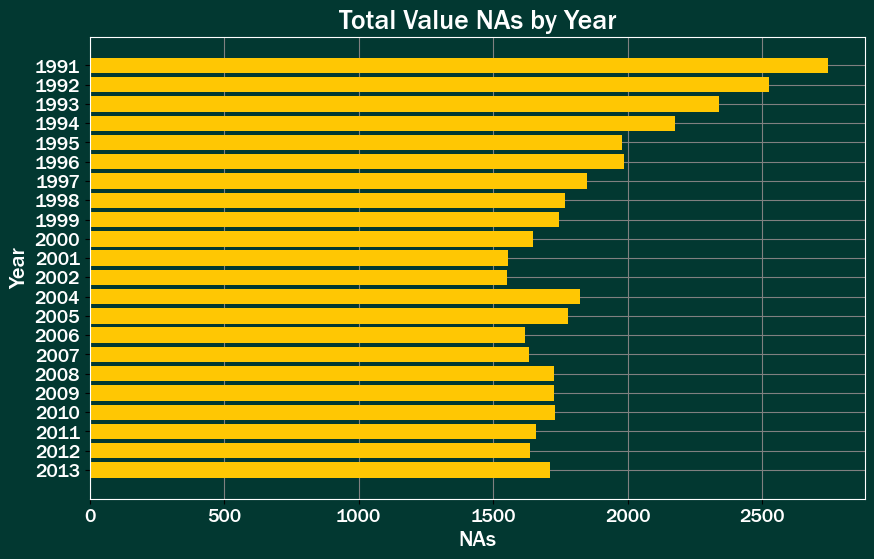

In [26]:
# Plot our view
na_year = df.total_value_usd.isnull().groupby(df['year']).sum().astype(int).reset_index(name="count")
na_year = na_year.sort_values(by=['year'], ascending=True)

na_year = na_year.sort_values(by=['year'], ascending=False)
bars = na_year['year']
height = na_year['count']
y_pos = np.arange(len(bars))


fig = plt.figure(facecolor=pres_green, figsize=(10,6))
ax = plt.axes()
ax.set_facecolor(pres_green)
ax.set_axisbelow(True)
plt.grid(color = "grey")
plt.barh(y_pos, height, color = pres_yellow)

plt.title("Total Value NAs by Year", color = pres_white)
plt.ylabel("Year", color = pres_white)
plt.xlabel("NAs", color = pres_white)
plt.yticks(y_pos, bars, color = pres_white)
plt.xticks(color = pres_white)
plt.show()

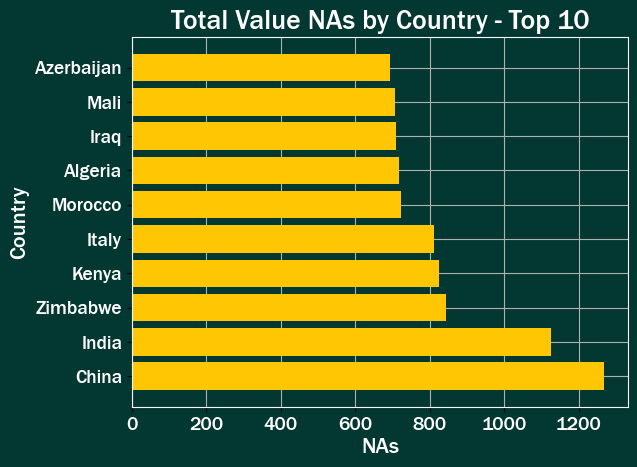

In [47]:
# By Country - Lets create a view as an example of how the Athena DB can be utilized

na_country = df.total_value_usd.isnull().groupby(df['area']).sum().astype(int).reset_index(name="count")
na_country = na_country.sort_values(by=['count'], ascending=False).head(10)


bars = na_country['area']
height = na_country['count']
y_pos = np.arange(len(bars))


fig = plt.figure(facecolor=pres_green)
ax = plt.axes()
ax.set_facecolor(pres_green)
ax.set_axisbelow(True)
plt.grid()
plt.barh(y_pos, height, color = pres_yellow)


plt.title("Total Value NAs by Country - Top 10", color = pres_white)
plt.ylabel("Country", color = pres_white)
plt.xlabel("NAs", color = pres_white)
plt.yticks(y_pos, bars, color = pres_white)
plt.xticks(color = pres_white)


plt.show()

It looks like India may have some issues if we remove the NAs. We'll check to see how many observations are left when we remove NAs.

Looks like we'll still be fine leaving India in. 

In [48]:
df_nona = df.dropna()
df_nona_china = df_nona[df_nona['area'] == "China"]
df_china = df[df['area'] == "China"]

print("China loses", df_china.shape[0] - df_nona_china.shape[0], "observations when we take out NAs leaving us with", df_nona_china.shape[0], "observations left for the country")

China loses 1268 observations when we take out NAs leaving us with 1460 observations left for the country


### Final clean before EDA
As we'll see below, fertilizers are fairly related to each other so we should be able to impute those missing values in a pipeline later. It likely isn't appropriate to impute the large number of missing total_value_usd's, so we will delete those.

In [49]:
df_clean = df[df['total_value_usd'].notna()]

# Note - we still expect to have nas for fertilizers since we're imputing those
nan_count = df_clean.isna().sum()
print(nan_count)

area                  0
item                  0
year                  0
production            0
nitrogen            173
phosphate          1376
potassium          1615
value                 0
avg_rain              0
avg_temp              0
total_value_usd       0
dtype: int64


## Target Variable - total_value_usd 
The target variable is the production (in tonnes) multiplied by the value (United States Dollar per tonne).

### Distribution 
Our target is very skewed to the right. Not suprising given that some crops likely produce a lot more value than most (for example corn in the USA is likely very high valued). Need to consider scaling after splitting.

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


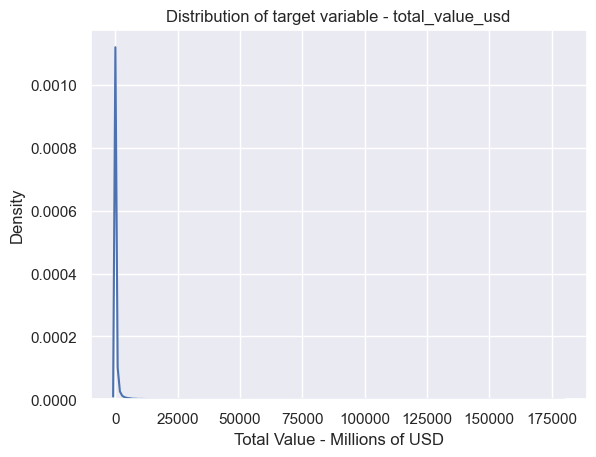

In [50]:
sns.set(style = "darkgrid")
sns.distplot(a = df_clean['total_value_usd']/1_000_000, hist = False, kde = True, rug = False)
plt.xlabel("Total Value - Millions of USD")
plt.ylabel("Density")
plt.title("Distribution of target variable - total_value_usd")
plt.show()

## Numeric Predictors 
The numeric predictors include the fertilizers used for agricultural purposes (nitrogen, phosphate, and potassium) and the weather featrues (avg_temp and avg_rain)

Fertilizer Distributions -
Still skewed heavily to the right, we'll likely need to make pipeline to standardize all numeric features

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

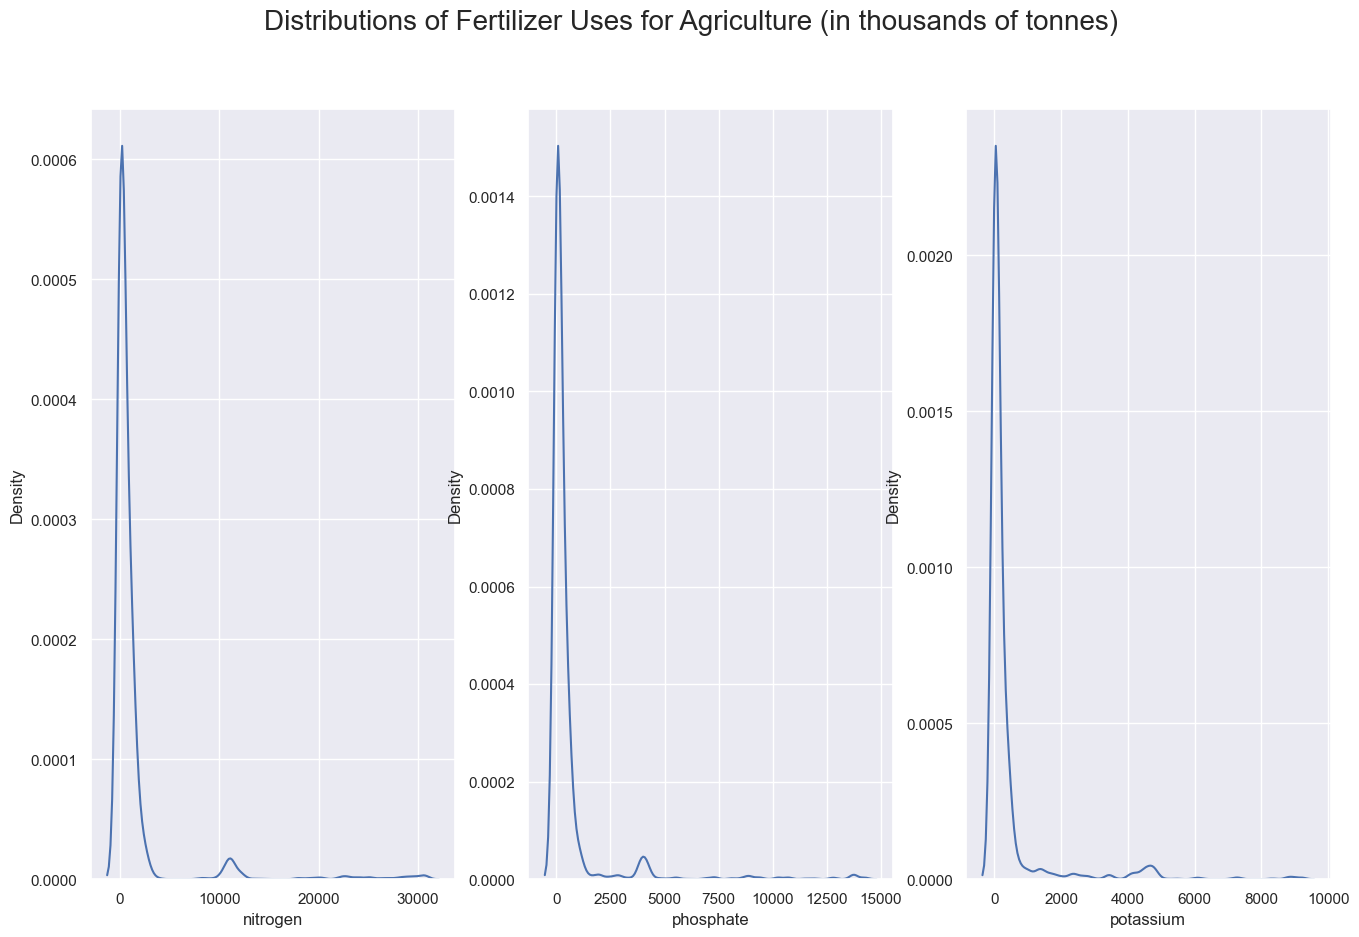

In [51]:
fig, axes = plt.subplots(1,3, figsize=(16,10))

fig.suptitle("Distributions of Fertilizer Uses for Agriculture (in thousands of tonnes)")

sns.distplot(ax = axes[0], a = df_clean['nitrogen']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['phosphate']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[2], a = df_clean['potassium']/1_000, hist = False, kde = True, rug = False)

plt.show()


Weather Predictors - These Look a lot better than other variables, regardless a standardization pipeline that works on all numeric features is still probbaly the most efficient option.

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


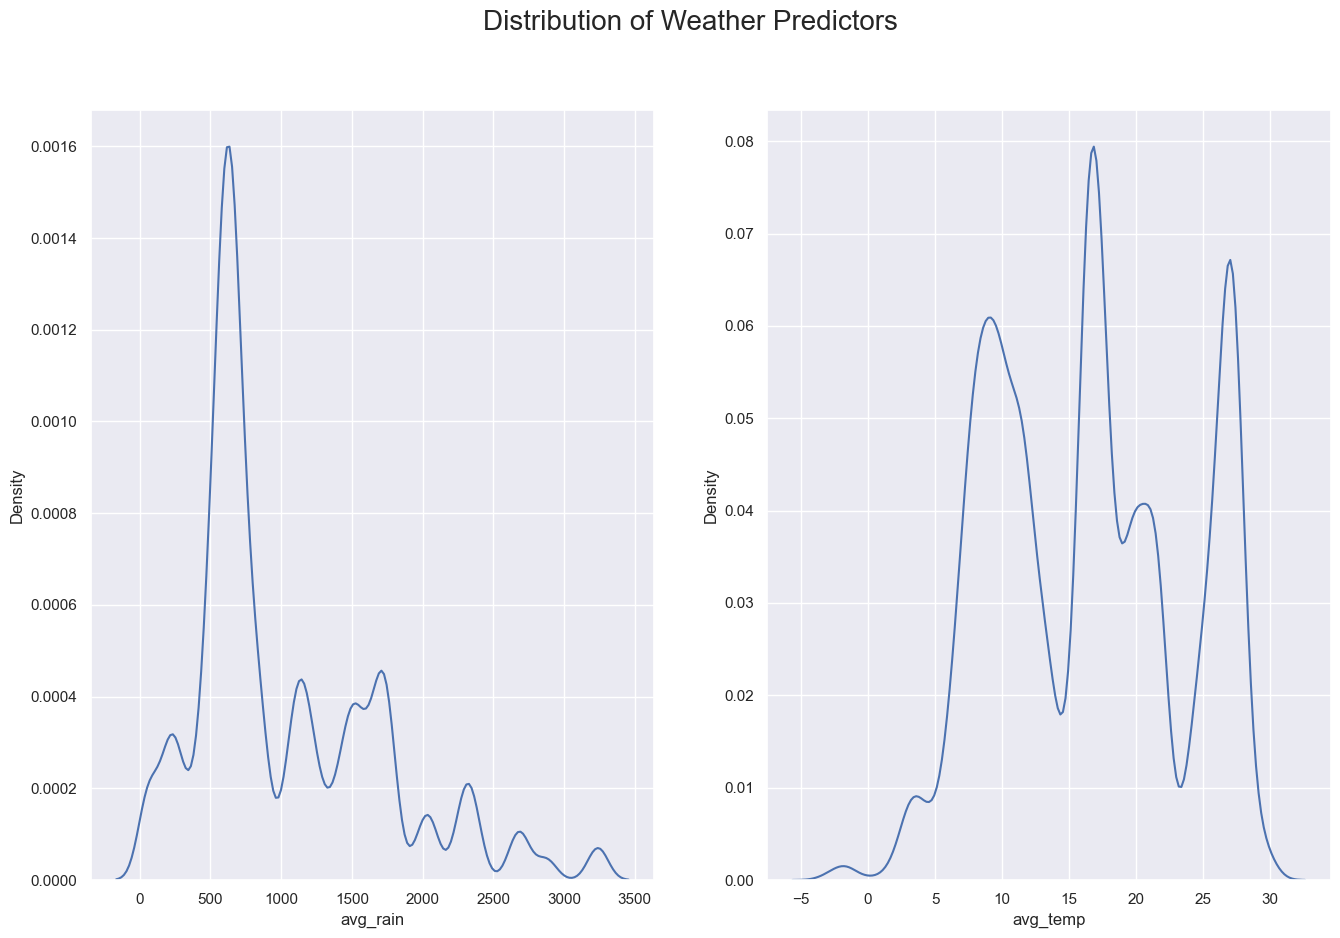

In [52]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

fig.suptitle("Distribution of Weather Predictors")

sns.distplot(ax = axes[0], a = df_clean['avg_rain'], hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['avg_temp'], hist = False, kde = True, rug = False)

plt.show()

Correlation Matrix for Numeric Features

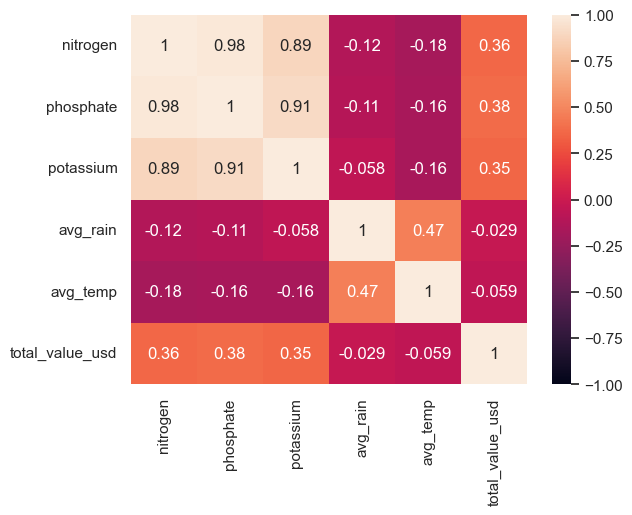

In [53]:
df_numeric = df_clean.select_dtypes(['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['year', 'production', 'value'], axis=1)
df_numeric_nona = df_numeric.dropna()


plt.clf()
sns.heatmap(df_numeric_nona.corr(), vmin= -1, vmax=1, annot=True)
plt.show()

## Maps
Doing the maps down here since we have NAs sorted out now.

Bring in our world data

In [54]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#### Fix Country names:
Some names aren't matching between world and df, need to match them since we're merging on them.

In [91]:
world.head(25)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
6,33580650.0,Asia,Uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586..."
7,8776109.0,Oceania,Papua New Guinea,PNG,24829,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ..."
8,270625568.0,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
9,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."


In [56]:
world_country = ['United States of America', 'Dem. Rep. Congo', 'Congo']
df_country = ["United States", "Congo, Dem. Rep.", "Congo, Rep."]

world2 = world

for (old, new) in zip(world_country, df_country):
    world2['name'] = world['name'].replace(old,new)



### Highest Ag Value 1991-2013

In [ ]:
val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)
gdf_value = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)
gdf_value.head(50)

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])


In [135]:
val_country = df_clean.total_value_usd.groupby(df['area']).sum().reset_index()
countries = df_clean['area'].unique()
countries = pd.Series(countries)

geos = world2[['name', 'geometry']]
geos

val_country = pd.merge(val_country, geos, how="inner", left_on=['area'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)
gdf_value = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)



In [136]:
gdf_value['total_value_usd'] = gdf_value[['total_value_usd']]/1_000_000_000_000


<AxesSubplot:>

<Figure size 2000x600 with 0 Axes>

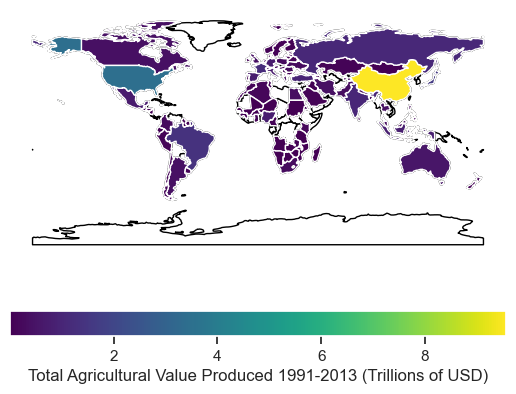

In [185]:
%%capture --no-display

plt.figure(figsize = (20,6))
base = world.plot(color = "white", edgecolor = 'black')
base.set_axis_off()

gdf_value.plot(ax = base, column = "total_value_usd",legend = True, cmap = "viridis",
               legend_kwds={'label': "Total Agricultural Value Produced 1991-2013 (Trillions of USD)",
                            'orientation':"horizontal"})



### Avg. Temperatures

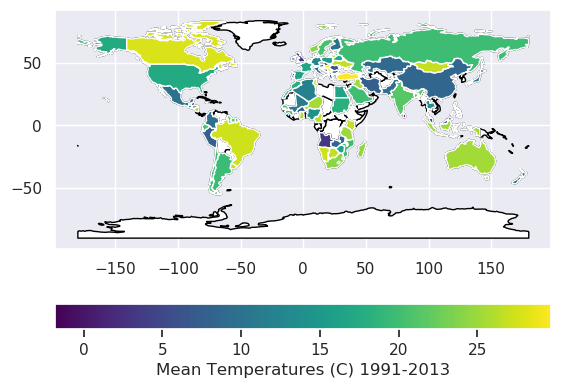

In [33]:
%%capture --no-display
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_temp"].mean()


val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_temp = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)


base = world.plot(color = "white", edgecolor = 'black')

gdf_temp.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Temperatures (C) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Avg. Rainfall

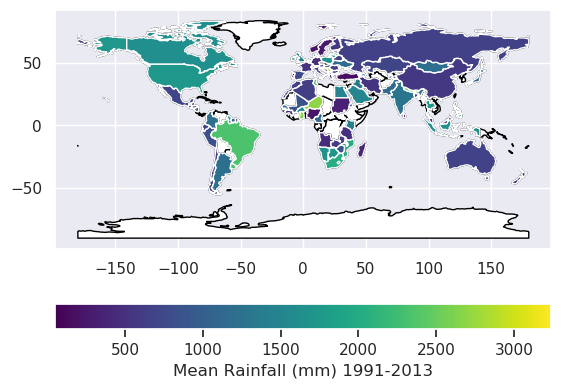

In [34]:
%%capture --no-display
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_rain"].mean()

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_rain = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)


base = world.plot(color = "white", edgecolor = 'black')

gdf_rain.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Rainfall (mm) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Nitrogen for Ag Use

In [35]:
val_country = df_clean.groupby(by="area")["nitrogen"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_nitrogen = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [36]:
gdf_nitrogen['value'] = gdf_nitrogen[['value']]/1_000_000

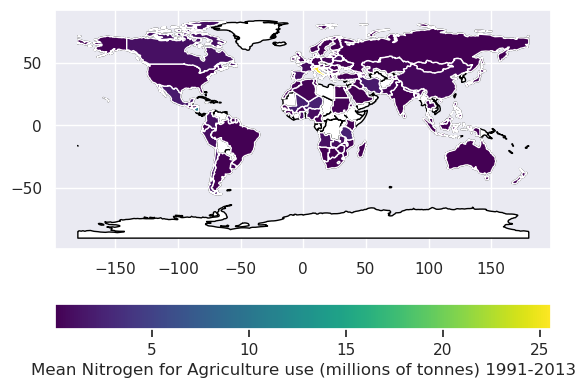

In [37]:
%%capture --no-display
base = world.plot(color = "white", edgecolor = 'black')

gdf_nitrogen.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Nitrogen for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})

plt.show()

### Phosphate

In [38]:
val_country = df_clean.groupby(by="area")["phosphate"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_phos = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [39]:
gdf_phos['value'] = gdf_phos[['value']]/1_000_000

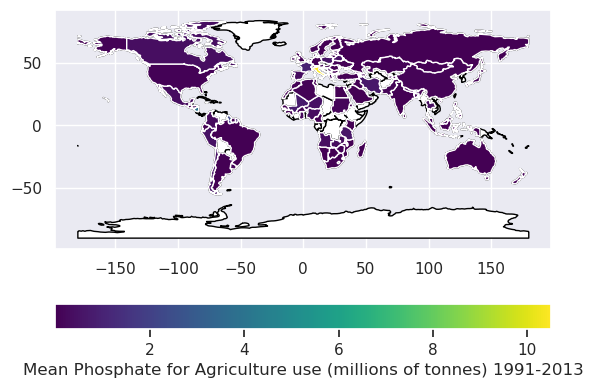

In [40]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_phos.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Phosphate for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Potassium

In [41]:
val_country = df_clean.groupby(by="area")["potassium"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_pot = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [42]:
gdf_pot['value'] = gdf_pot[['value']]/1_000_000

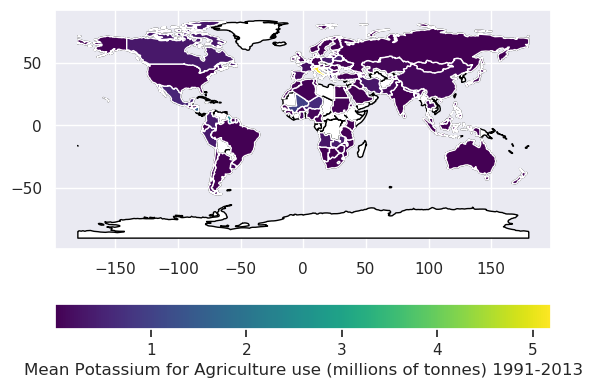

In [43]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_pot.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Potassium for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

## Categorical Anaylsis

#### "Area" and "item" are the only categorical variables

In [21]:
cat_df = pd.DataFrame(df, columns =['area', 'item'])

### "area" EDA:

In [22]:
#Finding the count of countries that are in the Area column:

print ("There are", cat_df['area'].nunique(), "different areas/countries in the dataset")

There are 103 different areas/countries in the dataset


In [23]:
#examining unique values of countries that are in the dataset
cat_df['area'].unique()


array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Croatia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Eritrea', 'Estonia', 'Finland', 'France',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea',
       'Guyana', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan',
       'Kenya', 'Latvia', 'Lebanon', 'Lithuania', 'Madagascar', 'Malawi',
       'Malaysia', 'Mali', 'Mauritius', 'Mexico', 'Mongolia', 'Morocco',
       'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qata

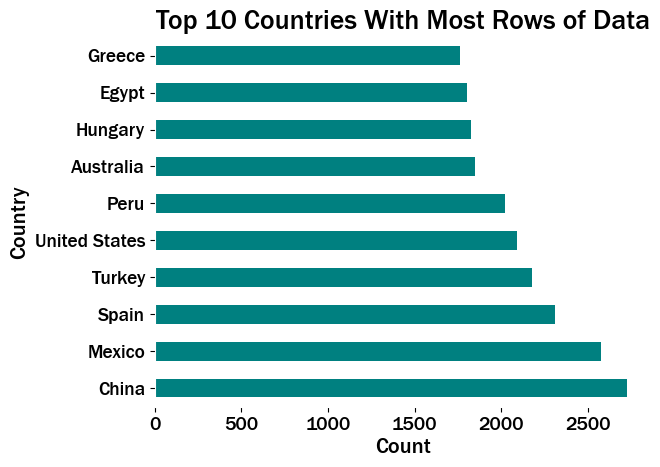

In [24]:
#frequency of each country: 
cat_df['area'].value_counts().head(10).plot(kind='barh', title= 'Top 10 Countries With Most Rows of Data', 
                                            color = 'teal')
plt.ylabel('Country')
plt.xlabel('Count')
plt.show()

#### Countries with most rows of data include China, Mexico, Spain & Turkey

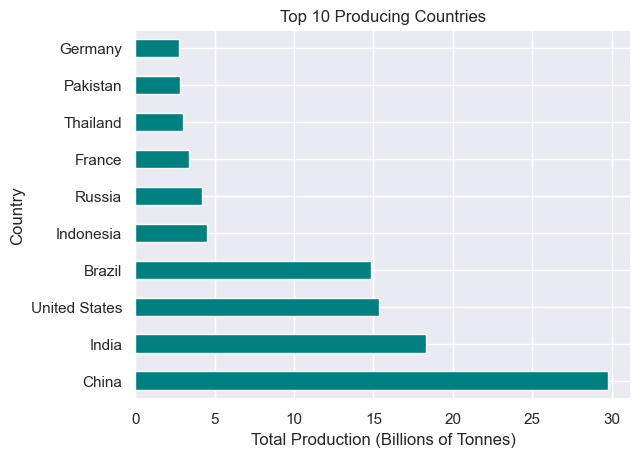

In [112]:
#Total production based on country
p_country = df.production.groupby(df['area']).sum().reset_index(name="sum")
p_country = p_country.sort_values(by=['sum'], ascending=False).head(10)


p_country2 = p_country
p_country2['sum'] = p_country2['sum']/1_000_000_000

p_country2.plot(kind='barh', title= 'Top 10 Producing Countries', x=('area'), y = ('sum'), 
                color = 'teal', legend = None)



plt.xlabel('Total Production (Billions of Tonnes)')
plt.ylabel('Country')
plt.show()

#### Countries with most production are China, India, United States and Brazil

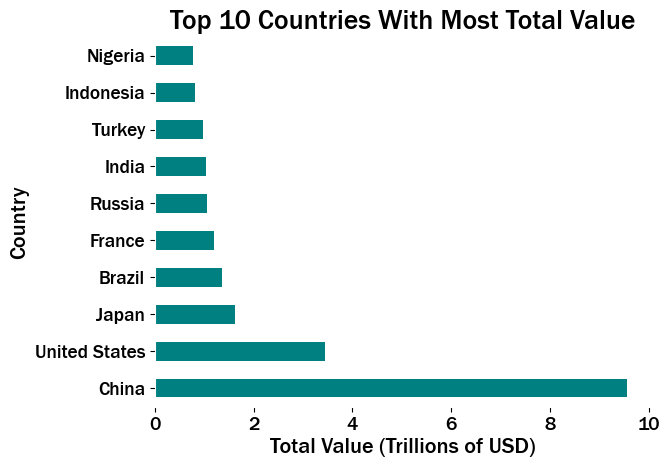

In [37]:
#Total value usd based on country
usd_country = df.total_value_usd.groupby(df['area']).sum().reset_index(name="sum")
usd_country = usd_country.sort_values(by=['sum'], ascending=False).head(10)

usd_country2 = usd_country
usd_country2['sum'] = usd_country2['sum']/1_000_000_000_000
usd_country2.plot(kind='barh', title= 'Top 10 Countries With Most Total Value', x=('area'), y = ('sum'), 
                 color = 'teal', legend = None)

plt.ylabel('Country')
plt.xlabel('Total Value (Trillions of USD)')
plt.show()

#### Countries with highest total value USD include China, United States, Japan, and Brazil 

### "Item" EDA

In [13]:
#Finding the count of Items that are in the Item column:

print ("There are", cat_df['item'].nunique(), "different commodities in the dataset")

There are 190 different commodities in the dataset


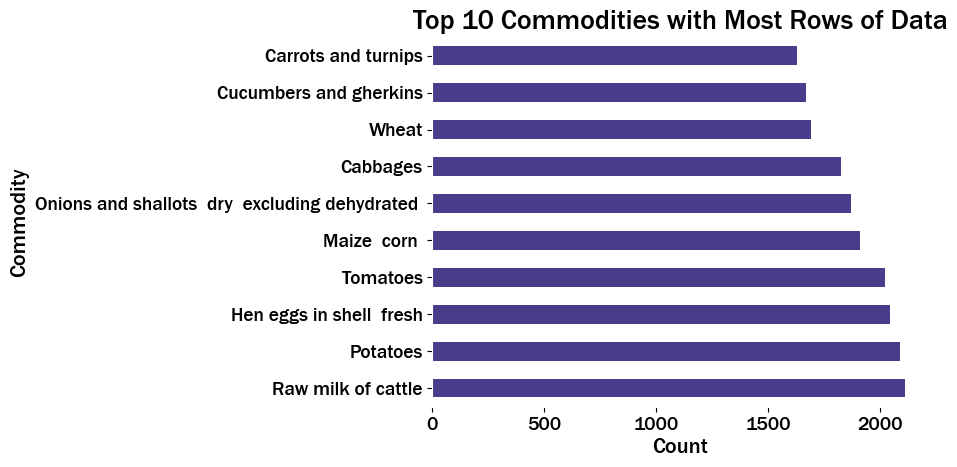

In [41]:
#frequency of each item: 
cat_df['item'].value_counts().head(10).plot(kind='barh', title= 'Top 10 Commodities with Most Rows of Data', 
                                            color = 'darkslateblue')

plt.xlabel('Count')
plt.ylabel('Commodity')
plt.show()

#### Top items with most rows of data are hen eggs in shell fresh, raw milk of acttle, potatoes, tomatoes, maize corn, etc. 

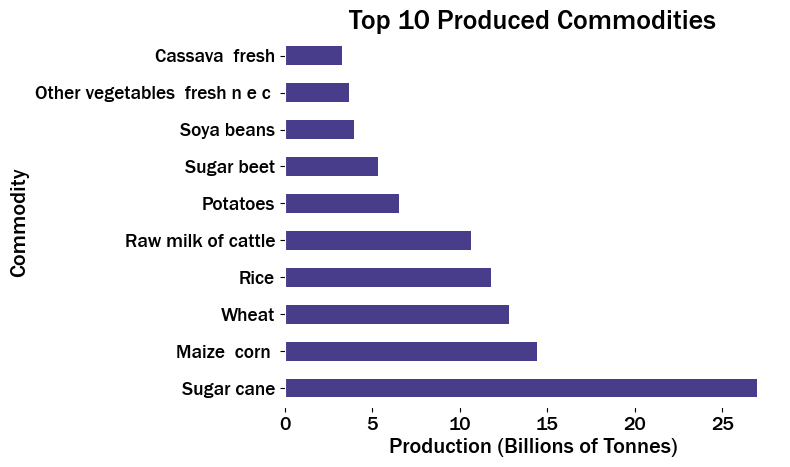

In [35]:
#Total production based on country
I_country = df.production.groupby(df['item']).sum().reset_index(name="sum")
I_country = I_country.sort_values(by=['sum'], ascending=False).head(10)

I_country2 = I_country
I_country2['sum'] = I_country2['sum']/1_000_000_000

I_country2.plot(kind='barh', title= 'Top 10 Produced Commodities', x=('item'), y = ('sum'), 
                legend=None, color = 'darkslateblue')

plt.xlabel('Production (Billions of Tonnes)')
plt.ylabel('Commodity')
plt.show()

In [44]:
usd_item2

,item,sum
155,Raw milk of cattle,3.233788
158,Rice,3.081799
80,Maize corn,2.405294
93,Meat of pig with the bone fresh or chilled,2.237632
187,Wheat,2.173645
86,Meat of cattle with the bone fresh or chilled,1.298443
145,Potatoes,1.153734
168,Soya beans,1.126967
64,Hen eggs in shell fresh,1.065166
179,Tomatoes,0.936187


#### Top produced items include sugar cane, maize corn, wheat and rice

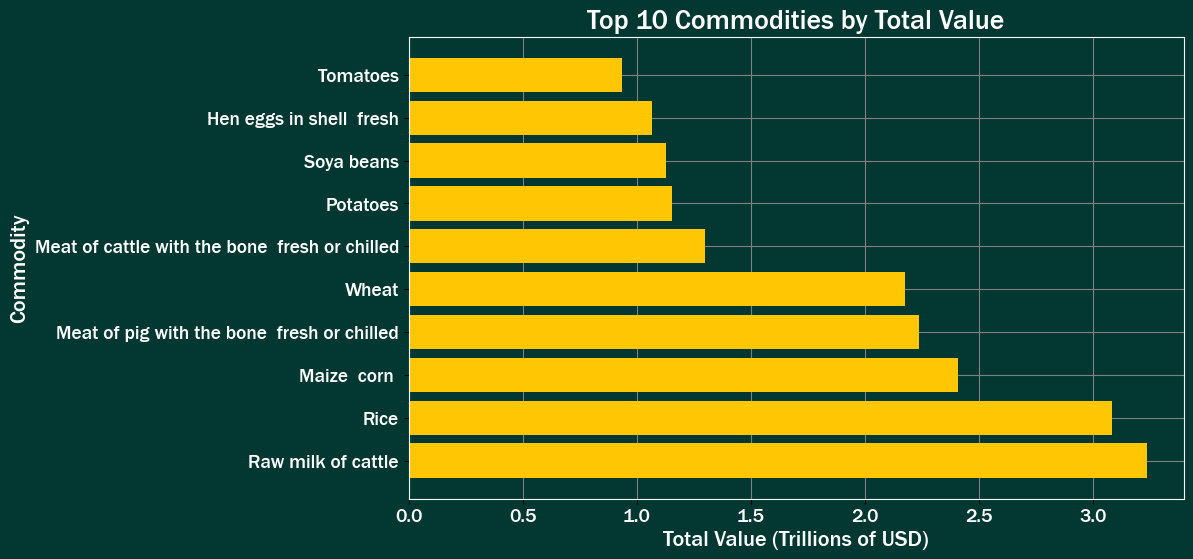

In [46]:
#Total value usd based on Item
usd_item = df.total_value_usd.groupby(df['item']).sum().reset_index(name="sum")
usd_item = usd_item.sort_values(by=['sum'], ascending=False).head(10)

usd_item2 = usd_item
usd_item2['sum'] = usd_item2['sum']/1_000_000_000_000

bars = usd_item2['item']
height = usd_item2['sum']
y_pos = np.arange(len(bars))


fig = plt.figure(facecolor=pres_green, figsize=(10,6))
ax = plt.axes()
ax.set_facecolor(pres_green)
ax.set_axisbelow(True)
plt.grid(color = "grey")
plt.barh(y_pos, height, color = pres_yellow)

plt.title("Top 10 Commodities by Total Value", color = pres_white)
plt.ylabel("Commodity", color = pres_white)
plt.xlabel("Total Value (Trillions of USD)", color = pres_white)
plt.yticks(y_pos, bars, color = pres_white)
plt.xticks(color = pres_white)
plt.show()

#### Items that have highest total value USD include raw milk of cattle, rice, maize corne and meat of pig with the bone fresh or chilled

### Outlier Analysis


In [54]:
summary =pd.DataFrame(df.describe())
summary

,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd,lat,long
count,113454.000000,1.108840e+05,1.113050e+05,1.090010e+05,1.080210e+05,72779.000000,113454.000000,113454.000000,7.253600e+04,113454.000000,113454.000000
mean,2001.954545,1.337219e+06,1.429205e+06,5.956547e+05,3.933367e+05,987.891786,1021.496219,17.001938,4.636290e+08,24.034191,15.719130
std,6.778856,1.099610e+07,4.353015e+06,1.799397e+06,1.124213e+06,1620.114512,681.223616,7.231138,2.745589e+09,25.584214,60.775976
min,1991.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,51.000000,-3.370000,0.000000e+00,-41.500083,-107.991707
25%,1996.000000,5.789000e+03,4.270000e+04,1.800000e+04,9.286000e+03,226.200000,591.000000,10.330000,6.381282e+06,7.877396,-4.837979
50%,2001.500000,4.205850e+04,2.010000e+05,7.500000e+04,4.900000e+04,451.600000,748.000000,16.960000,3.418865e+07,31.172821,19.999962
75%,2008.000000,2.720000e+05,9.146600e+05,3.273870e+05,1.993220e+05,1089.000000,1485.000000,24.100000,1.806696e+08,42.638426,44.673665
max,2013.000000,7.680904e+08,3.080070e+07,1.425946e+07,9.217027e+06,40039.700000,3240.000000,30.420000,1.791078e+11,64.686314,172.834408


In [55]:
num_df = pd.DataFrame(df, columns =['production', 'nitrogen', 'phosphate', 'potassium', 'value', 'avg_rain','avg_temp', 'total_value_usd'])
num_df.head()

,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,260797.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN
1,44833.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN
2,42820.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN
3,396497.0,743742.0,104000.0,29700.0,NaN,51.0,20.09,NaN
4,234000.0,743742.0,104000.0,29700.0,148.7,51.0,20.09,34795800.0


#### Boxplot for numerical data:

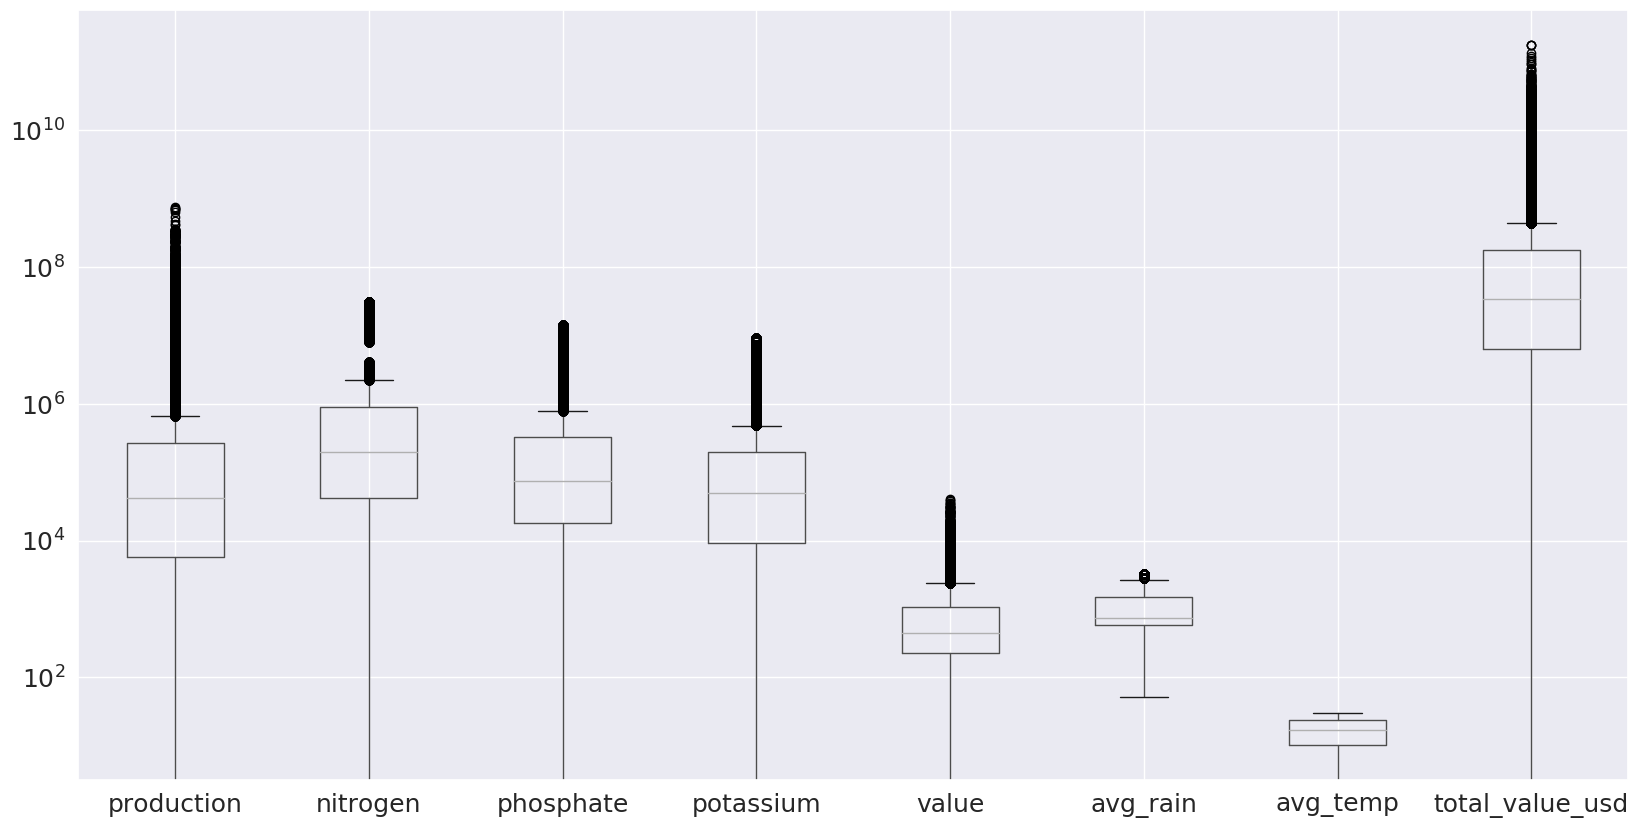

In [56]:
num_df.boxplot(figsize=(20,10), fontsize = 18)
plt.semilogy()
plt.show()

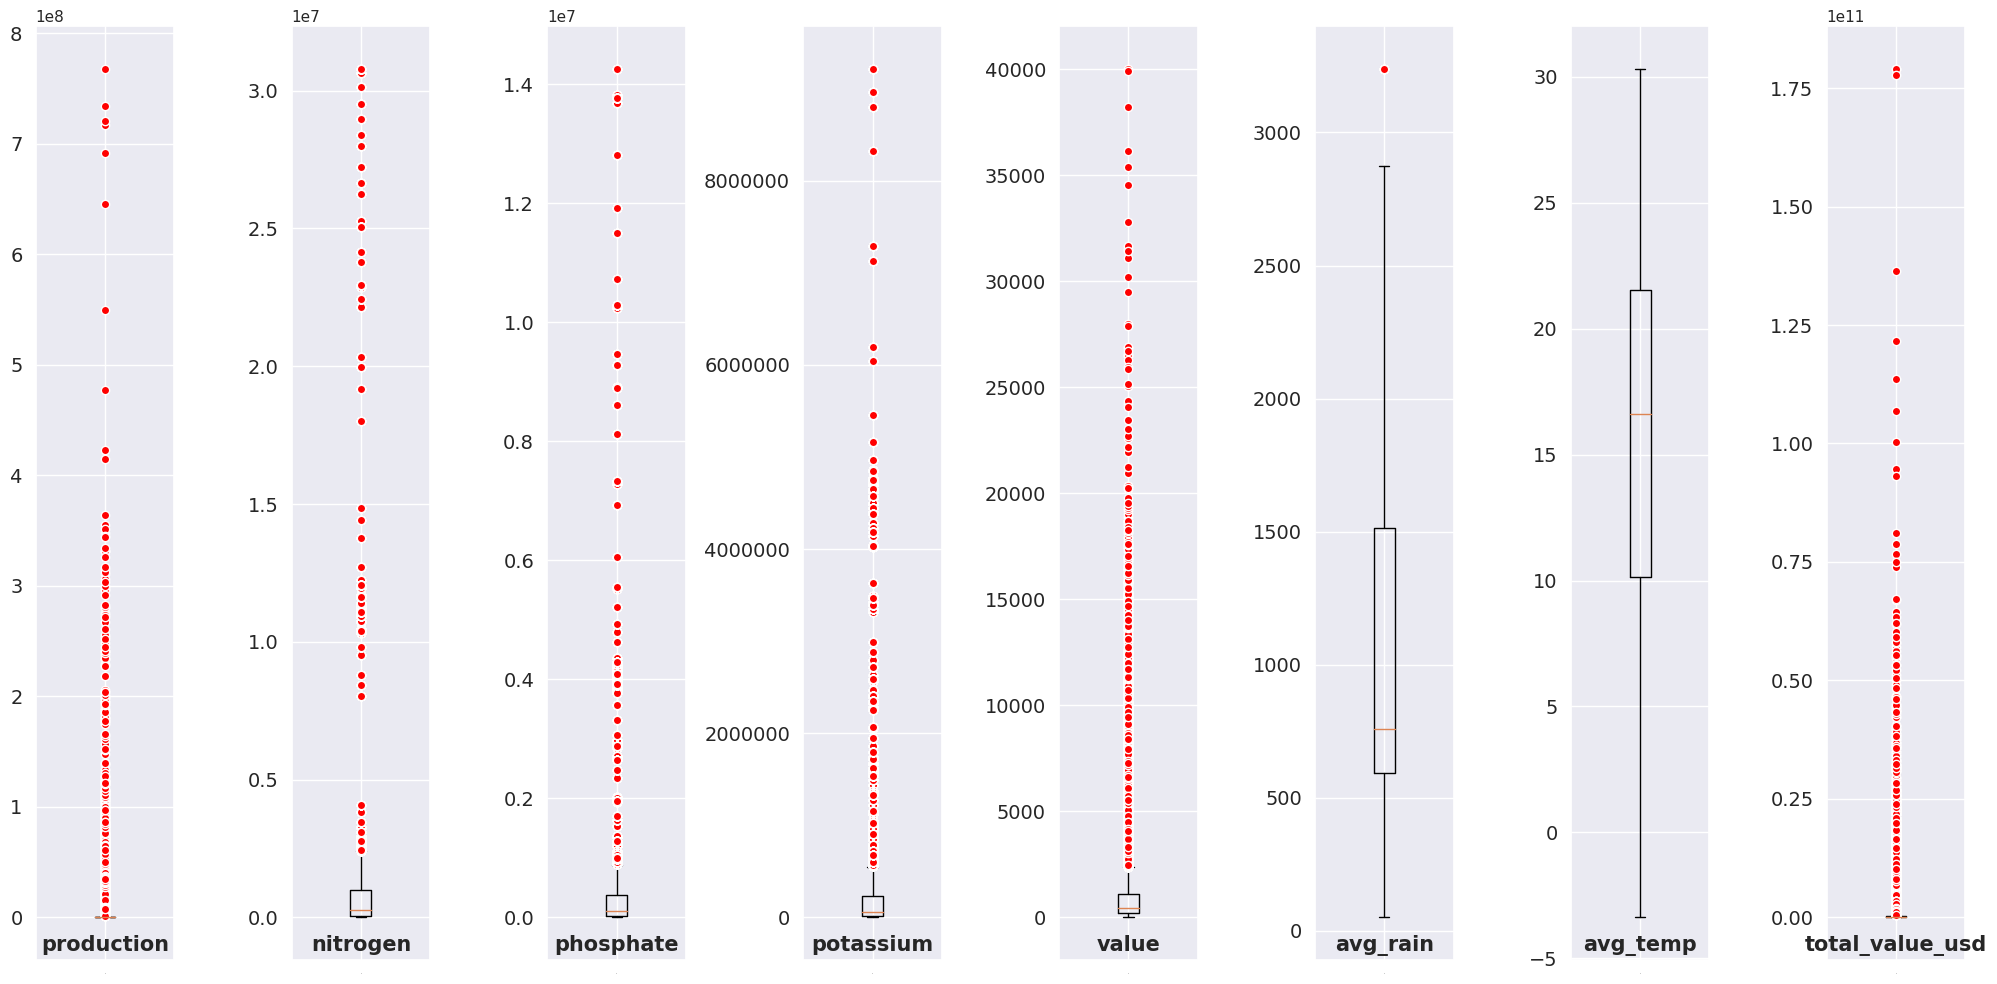

In [57]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

num_df = num_df.dropna()

fig, axs = plt.subplots(1, len(num_df.columns), figsize=(20,10))

for col, ax in enumerate(axs.flat):
    ax.boxplot(num_df.iloc[:,col], flierprops=red_circle)
    ax.set_title(num_df.columns[col], fontsize=15, fontweight='bold', y = 0)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize = 0)
    
plt.tight_layout()
plt.show()

#### It looks like most of the numerical columns have a large amount of outliers. Outliers should be kept considering significant amount of data. Average rain and average temp could possibly be resolved for outliers.

# Model Evaluation

## Final Rankings
Will store here so we can code graph adjustments locally    

In [156]:
Models = ['Lin. Reg.', 'ENet', 'XGBoost', 'Linear Learner']
RMSE = [16.76, 16.29, 14.53, 17.28]
rho = [0.57, 0.59, 0.63, 0.53]
p = [0, 0, 0, 0] # These were all essentially zero

Results = pd.DataFrame(list(zip(Models, RMSE, rho, p)),
                       columns = ['Model', 'RMSE', 'Spearman_r', 'Spearman_p'])
Results

,Model,RMSE,Spearman_r,Spearman_p
0,Lin. Reg.,16.76,0.57,0
1,ENet,16.29,0.59,0
2,XGBoost,14.53,0.63,0
3,Linear Learner,17.28,0.53,0


In [158]:
Res_rmse

,Model,RMSE,Spearman_r,Spearman_p
3,Linear Learner,17.28,0.53,0
0,Lin. Reg.,16.76,0.57,0
1,ENet,16.29,0.59,0
2,XGBoost,14.53,0.63,0


### RMSE Plot

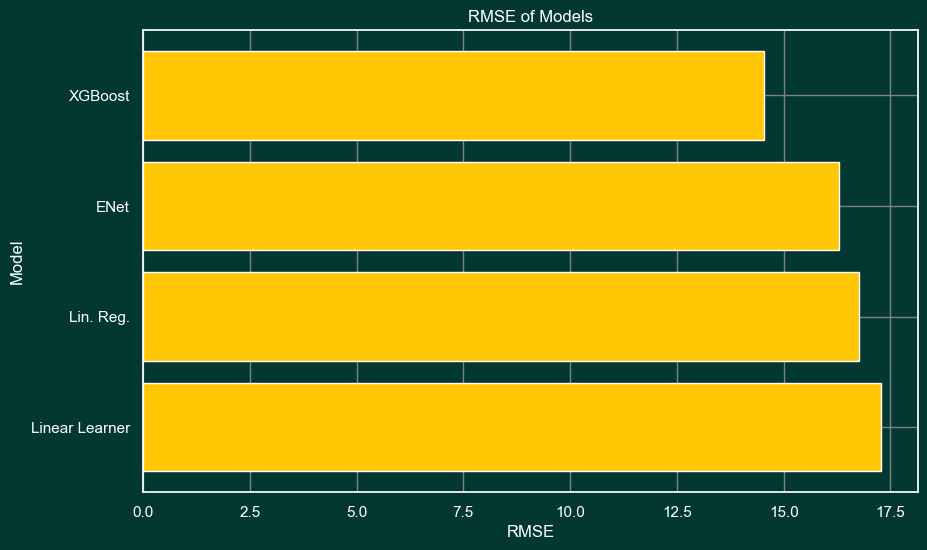

In [160]:
Res_rmse = Results.sort_values(by=['RMSE'], ascending=False)

bars = Res_rmse['Model']
height = Res_rmse['RMSE']
y_pos = np.arange(len(bars))


fig = plt.figure(facecolor=pres_green, figsize=(10,6))
ax = plt.axes()
ax.set_facecolor(pres_green)
ax.set_axisbelow(True)
plt.grid(color = "grey")
plt.barh(y_pos, height, color = pres_yellow)

plt.title("RMSE of Models", color = pres_white)
plt.ylabel("Model", color = pres_white)
plt.xlabel("RMSE", color = pres_white)
plt.yticks(y_pos, bars, color = pres_white)
plt.xticks(color = pres_white)
plt.show()

### Spearman Plot

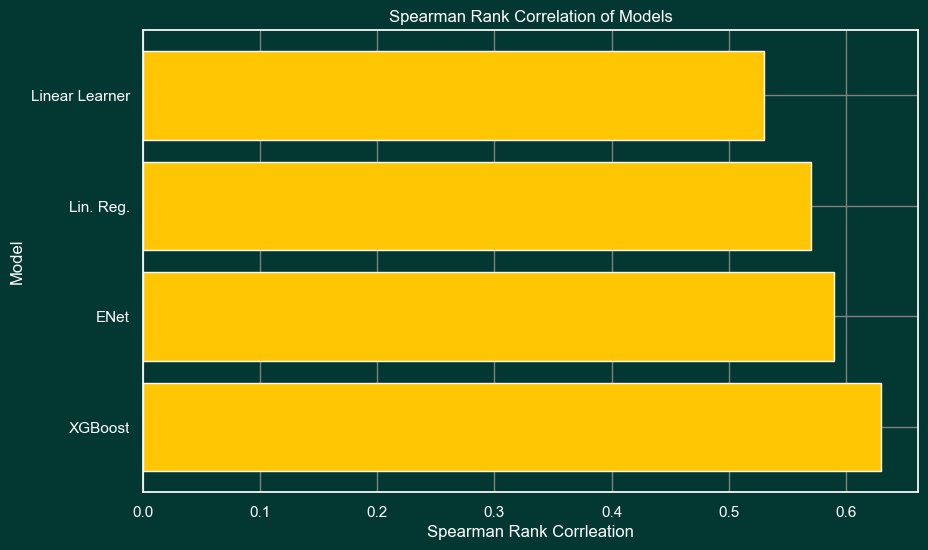

In [163]:
Res_spear = Results.sort_values(by=['Spearman_r'], ascending=False)

bars = Res_spear['Model']
height = Res_spear['Spearman_r']
y_pos = np.arange(len(bars))


fig = plt.figure(facecolor=pres_green, figsize=(10,6))
ax = plt.axes()
ax.set_facecolor(pres_green)
ax.set_axisbelow(True)
plt.grid(color = "grey")
plt.barh(y_pos, height, color = pres_yellow)

plt.title("Spearman Rank Correlation of Models", color = pres_white)
plt.ylabel("Model", color = pres_white)
plt.xlabel("Spearman Rank Corrleation", color = pres_white)
plt.yticks(y_pos, bars, color = pres_white)
plt.xticks(color = pres_white)
plt.show()

### Scatterplot for XGBoost 

In [167]:
xgb_merge

,-41.5000831,172.8344077,2013,Oats,1,1732.0,13.57,0.4945142333225075,0.3621982627848636,0.14328750389262893,130453880.0,4
0,-41.500083,172.834408,2013,Game meat fresh chilled or frozen,2,1732.0,13.57,0.494514,0.362198,0.143288,1.304539e+08,3
1,-41.500083,172.834408,2013,Maize corn,3,1732.0,13.57,0.494514,0.362198,0.143288,8.217638e+08,8
2,-41.500083,172.834408,2013,Barley,4,1732.0,13.57,0.494514,0.362198,0.143288,1.115498e+08,1
3,-41.500083,172.834408,2013,Wheat,5,1732.0,13.57,0.494514,0.362198,0.143288,5.894633e+08,6
4,-41.500083,172.834408,2013,Apples,6,1732.0,13.57,0.494514,0.362198,0.143288,8.047597e+08,7
...,...,...,...,...,...,...,...,...,...,...,...,...
3438,64.686314,97.745306,2013,Meat of cattle with the bone fresh or chilled,29,460.0,4.73,0.626861,0.235328,0.137812,4.572068e+09,30
3439,64.686314,97.745306,2013,Potatoes,30,460.0,4.73,0.626861,0.235328,0.137812,5.627085e+09,33
3440,64.686314,97.745306,2013,Meat of pig with the bone fresh or chilled,31,460.0,4.73,0.626861,0.235328,0.137812,3.551997e+09,28
3441,64.686314,97.745306,2013,Wheat,32,460.0,4.73,0.626861,0.235328,0.137812,4.923993e+09,31


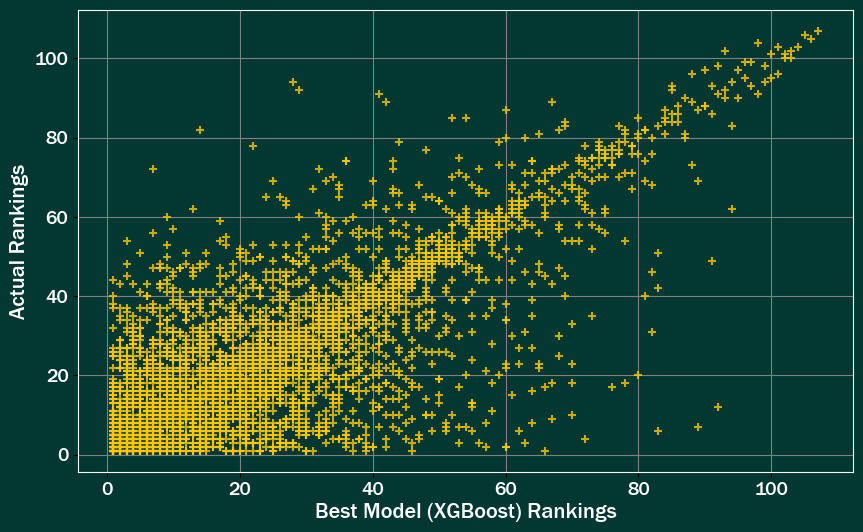

In [4]:
# read in data
xgb_merge = pd.read_csv('XGRankings.csv')

fig = plt.figure(facecolor=pres_green, figsize=(10,6))
ax = plt.axes()
ax.set_facecolor(pres_green)
ax.set_axisbelow(True)
plt.grid(color = "grey")

sns.regplot(x = xgb_merge['xgb_rank'], y = xgb_merge['group_rank'], fit_reg = False, marker = "+", color = pres_yellow)
plt.xlabel("Best Model (XGBoost) Rankings", color = pres_white)
plt.ylabel("Actual Rankings", color = pres_white)
plt.yticks(color = pres_white)
plt.xticks(color = pres_white)
plt.show()